# Lab 4: Oracles and The Deutsch-Jozsa Algorithm by IBM Quantum

Many quantum algoritms revolve around the notion of so called $\textit{oracles}$. An oracle is a function that can be considered as a 'black box'. We generally want to find out specific properties of this function. We do this by asking questions to the oracle (*querying*). The query complexity is then defined as the minimum number of queries in order to find these properties.


To get familiar with the use of oracles we will now consider the Deutsch-Josza problem. We will see that the quantum solution has a drastically lower query complexity than its classical counterpart.


## 3.1: Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant.

The Deutsch-Jozsa algorithm was the first example of a quantum algorithm that performs better than the best classical algorithm. It showed that there can be advantages to using a quantum computer as a computational tool for a specific problem.


In the Deutsch-Josza problem you are given an unknown orcale. This is in Qiskit implemented by the function:

In [1]:
# pip install qiskit

In [2]:
# pip install qiskit-aer

In [3]:
# pip install qiskit-ibm-runtime

In [4]:
# pip install pylatexenc

In [5]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit.library import Diagonal

In [6]:
def dj_problem_oracle(problem, to_gate=True):
    """Returns a 5-qubit Deutsch-Joza Oracle"""
    qc = QuantumCircuit(5)
    int(problem)
    if problem == 1:
        for q in range(4):
            qc.cx(q, 4)
    elif problem == 2:
        qc.cx(0, 4)
        qc.cx(0, 4)
    elif problem == 3:
        qc.ccx(0,2,4)
        qc.ccx(1,2,4)
        for q in range(3):
            qc.x(q)
        qc.ccx(0,2,4)
        qc.ccx(1,3,4)
    elif problem == 4:
        qc.cx(2,4)
    else:
        print("There are only currently 4 oracles in this problem set, returning empty (balanced) gate")
    if to_gate:
        return qc.to_gate()
    else:
        return qc

def hsp_oracle(
    seed: int,
    output: bool=False,
    shifted: bool=False,
    fourier_transformed: bool=False
) -> QuantumCircuit:
    """
    Returns 4-qubit hidden shift problem oracle according to input options.
    Args:
        seed (int): the seed for the random shift string s.
        output (bool): if true, returns a 5-qubit circuit with the output register.
        shifted (bool): if true, apply the shift operation on both sides of the function.
        fourier_transformed (bool): if true, apply the Fourier transformed function instead.
    Returns:
        QuantumCircuit: oracle circuit with 4-qubit if ouput==False, 5-qubit if output==True.
    """

    np.random.seed(seed)
    s = f'{np.random.randint(0, 2**4):4b}'
    s = s[::-1]
    n = 4
    oracle = QuantumCircuit(4+output)

    # Apply the shift operation according to 'shifted'
    if shifted:
        for i in range(n):
            if s[i] == '1':
                oracle.x(i+output)

    # Apply the function according to output
    # f(x, y) = x·y = tilde f(x, y)
    if output:
        oracle.ccx(1,3,0)
        oracle.ccx(2,4,0)
    else:
        oracle.cz(0,2)
        oracle.cz(1,3)

    # Apply the shift operation according to 'shifted'
    if shifted:
        for i in range(n):
            if s[i] == '1':
                oracle.x(i+output)

    # Name the oracle
    if shifted and fourier_transformed:
        oracle.name = 'Oracle g tilde'
    elif shifted:
        oracle.name = 'Oracle g'
    elif fourier_transformed:
        oracle.name = 'Oracle f tilde'
    else:
        oracle.name = 'Oracle f'

    return oracle.to_gate()

In [7]:
oraclenr = 1 # determines the oracle (can range from 1 to 4)
oracle = dj_problem_oracle(oraclenr) # gives one out of 4 oracles
oracle.name = "DJ-Oracle"

This function gives a certain oracle with 5 input qubits. The last qubit ($q_4$) will be the output. In order to get a feeling for the oracle, let us create a circuit to which we add the oracle such that we can pass it different input strings and then measure the output of $q_4$. This corresponds to the classical way of determining whether the oracle is balanced or constant.

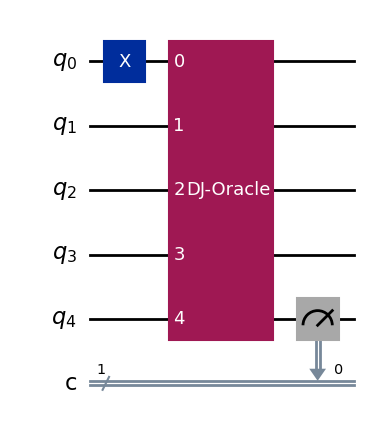

In [8]:
def dj_classical(n, input_str):

    # build a quantum circuit with n qubits and 1 classical readout bit
    dj_circuit = QuantumCircuit(n+1,1)

    # Prepare the initial state corresponding to your input bit string
    for i in range(n):
        if input_str[i] == '1':
            dj_circuit.x(i)

    # append oracle
    dj_circuit.append(oracle, range(n+1))

    # measure the fourth qubit
    dj_circuit.measure(n,0)

    return dj_circuit

n = 4 # number of qubits
input_str = '1000'
dj_circuit = dj_classical(n, input_str)
dj_circuit.draw(output="mpl") # draw the circuit

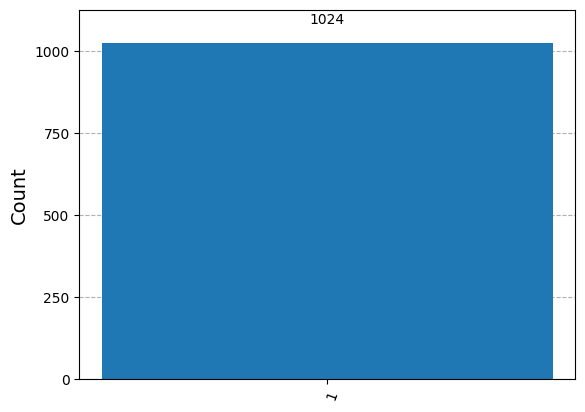

In [9]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
results = qasm_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

Now we simulate the results to find the outcome of this circuit. Try different input bit strings to see the corresponding outputs!

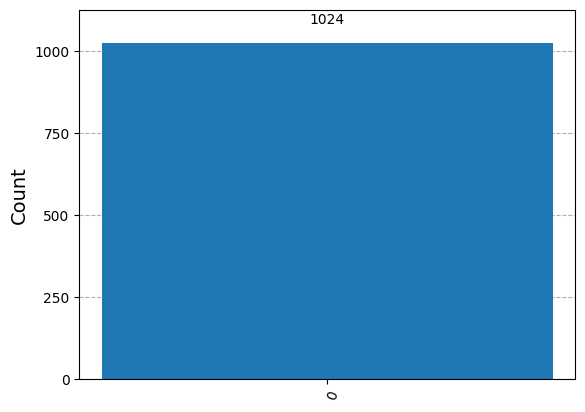

In [10]:
input_str = '1111'
dj_circuit = dj_classical(n, input_str)
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
results = qasm_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

Do you already have an idea whether the oracle is balanced or constant? How many inputs would you need to check minimally and maximally for this oracle?

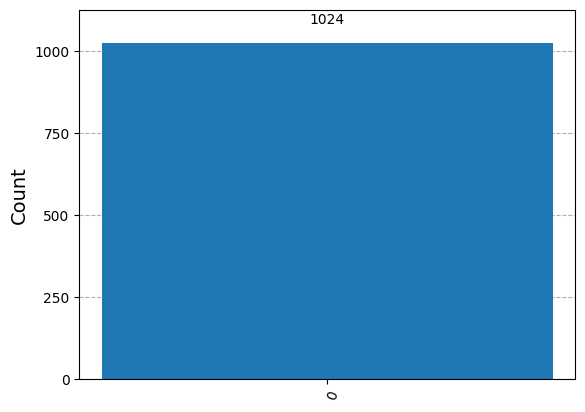

In [11]:
input_str = '0011'
dj_circuit = dj_classical(n, input_str)
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
results = qasm_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

In [12]:
def lab1_ex7():
    min_nr_inputs = 2# put your answer here
    max_nr_inputs = 9# put your answer here
    return [min_nr_inputs, max_nr_inputs]

## 3.2: Quantum Solution to the Deutsch-Josza Problem

Using a quantum computer, we can find out if the oracle is constant or balanced with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below we will walk through the algorithm.

Prepare two quantum registers. The first is an $n$-qubit register initialised to $|0\rangle$, and the second is a one-qubit register initialised to $|-\rangle =\frac{1}{\sqrt{2}}\left(|0\rangle - |1 \rangle \right)$. Note, that with Qiskit states are described as $\vert b_3 b_2 b_1 b_0\rangle_{q_3q_2q_1q_0}$, i.e. just like for binary numbers, the last bit $b_0$ corresponds to the state of the first qubit. Thus, we want to initialize the state $$\vert \psi_0 \rangle = \vert -\rangle \otimes \vert0\rangle^{\otimes n}.$$

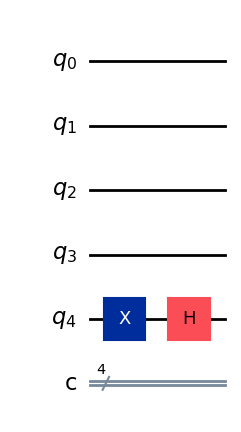

In [13]:
n=4
def psi_0(n):
    qc = QuantumCircuit(n+1,n)

    # Build the state (|00000> - |10000>)/sqrt(2)

    qc.x(n)
    qc.h(n)
    #
    #
    # FILL YOUR CODE IN HERE
    #
    #
    return qc

dj_circuit = psi_0(n)
dj_circuit.draw(output='mpl')

Applying the quantum bit oracle to any state $\vert x\rangle \vert y\rangle$ would yield the state $\vert x\rangle \vert y \oplus f(x)\rangle$.
As we have prepared the state $|y\rangle$, which corresponds to the state on the last qubit $q_n$, in the state $|-\rangle$, the output of the oracle for any input bitstring $x$ is given by:
$$ \frac{1}{\sqrt{2}}\vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) = \frac{1}{\sqrt{2}} (-1)^{f(x)}|x\rangle (|0\rangle - |1\rangle ) = (-1)^{f(x)}|x\rangle |-\rangle.$$
Thus, we have created a phase oracle acting on the bit string $x$.

Before applying the oracle, we need to create our input state on the first $n$ qubits though. For that we want an equal superposition state, so that the total state on all $n+1$ qubits is given by $$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$

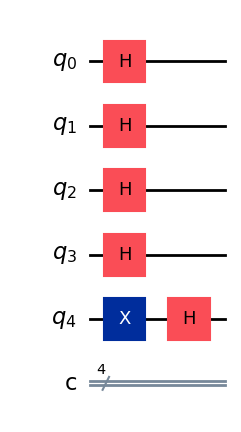

In [14]:
def psi_1(n):

    # obtain the |psi_0> = |00001> state
    qc = psi_0(n)

    # create the superposition state |psi_1>
    for i in range(n) :
        qc.h(i)
    #
    #
    # FILL YOUR CODE IN HERE
    #
    #
    return qc

dj_circuit = psi_1(n)
dj_circuit.draw(output='mpl')

Now we are ready to apply our oracle to the prepared superposition state $\vert \psi_1 \rangle$. This gives the state
$$ \vert \psi_2 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle (|0\rangle - |1\rangle ) = \frac{1}{\sqrt{2^{n}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle |-\rangle.$$

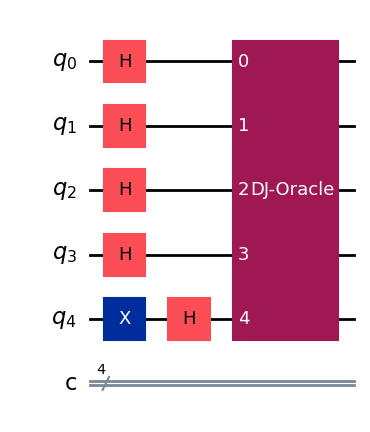

In [15]:
def psi_2(oracle,n):

    # circuit to obtain psi_1
    qc = psi_1(n)

    # append the oracle
    qc.append(oracle, range(n+1))

    return qc

dj_circuit = psi_2(oracle, n)
dj_circuit.draw(output='mpl')

In the final part of our algorithm we disregard the outcome on our second register and we apply an n-fold Hadamard to our first register. Afterwards we measure the outcome on these qubits.

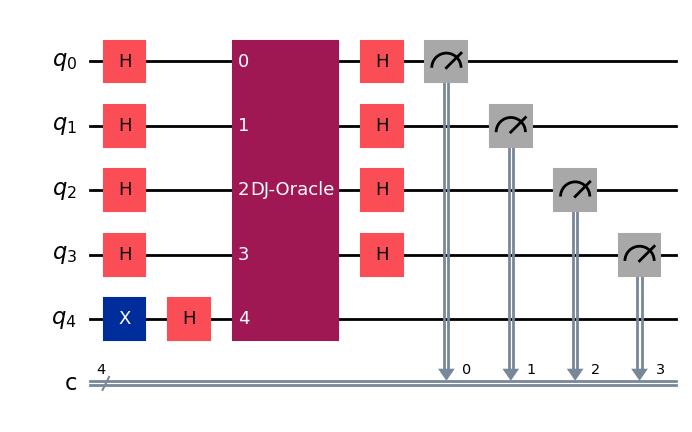

In [16]:
def lab1_ex8(oracle, n): # note that this exercise also depends on the code in the functions psi_0 (In [24]) and psi_1 (In [25])
    qc = psi_2(oracle, n)

    # apply n-fold hadamard gate
    for i in range(n) :
        qc.h(i)
    #
    #
    # FILL YOUR CODE IN HERE
    #
    #

    # add the measurement by connecting qubits to classical bits
    for i in range(n) :
        qc.measure(i,i)
    #
    #
    # FILL YOUR CODE IN HERE
    #
    #
    return qc

dj_circuit = lab1_ex8(oracle, n)
dj_circuit.draw(output='mpl')

At this point the second single qubit register may be ignored. Applying a Hadamard gate to each qubit in the first register yields the state:
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y}
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)+x \cdot y} \right]
                    \vert y \rangle,
        \end{aligned}
        $$
       
where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.

Let us now run the circuit including the measurement of the first register on the simulator:

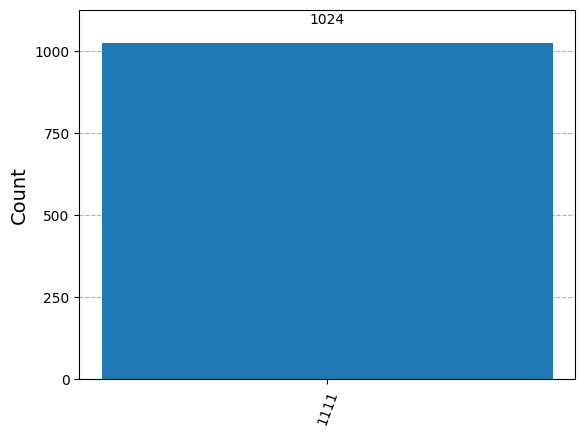

In [17]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)

results = qasm_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

As we learnt in the lecture, if the output is the zero bit string, we know that the oracle is constant. If it is any other bit string, we know that it is balanced. You may also check the other oracles by just changing the oracle number in the beginning where the oracle is defined!